# Projeto 13.1 - Rede Neural Convolucional CIFAR10

# 1. Importando bibliotecas

In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision

torch.__version__

'2.5.0'

In [2]:
torch.set_default_device("mps")
device = torch.device("mps")

# torch.set_default_device("cpu")
# device = torch.device("cpu")

In [3]:
print(torch.backends.mps.is_available())  # Deve retornar True
print(torch.backends.mps.is_built())  # Deve retornar True

True
True


## 2. Importando dados

In [4]:
torch.manual_seed(123)

In [5]:
# transform_train = transforms.Compose([
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.RandomAffine(degrees = 7, 
#                                                               translate = (0, 0.07), # horizontal and vertical shifts
#                                                               shear = 7,
#                                                               scale = (1, 1.2) # zoom range
#                                                               ),
#                                       transforms.ToTensor()
#                                       ])

In [6]:
transform_train = transforms.ToTensor()

In [7]:
transform_test = transforms.ToTensor()

In [8]:
train = datasets.CIFAR10(root = '.', train = True, download = True, transform = transform_train)
test = datasets.CIFAR10(root = '.', train = False, download = True, transform = transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train.data.shape

(50000, 32, 32, 3)

In [10]:
test.data.shape

(10000, 32, 32, 3)

In [11]:
train.data[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [12]:
32 * 32 * 3

3072

In [13]:
train.targets[0]

6

In [14]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128)

In [15]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [16]:
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

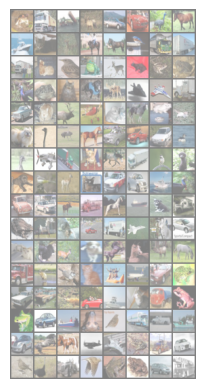

In [17]:
imshow(torchvision.utils.make_grid(images))


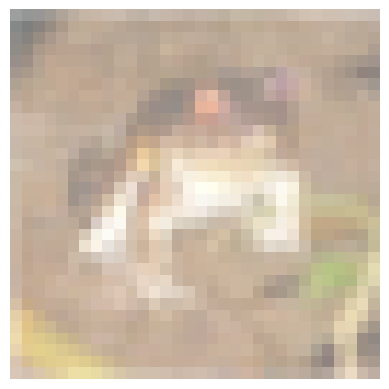

In [18]:
imshow(images[0])

## 3. Construção do modelo

In [19]:
class classificador(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)) # operador de convolucao
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)) # operador 2 de convolucao
        
        self.activation = nn.ReLU()
        self.bnorm = nn.BatchNorm2d(num_features=32) # normalizacao dos dados em camadas ocultas

        self.pool = nn.MaxPool2d(kernel_size=(2,2))

        self.flatten = nn.Flatten()

        # 800 -> 128
        # output = (input - filter + 1) / (stride)
        # convolucao 1: (28 - 3 + 1) / 1 (stride) = 26
        # pooling 1: 13 x 13
        # convolucao 1: (13 - 3 + 1) / 1 (stride) = 26
        # pooling 2: 5x5
        # 5 * 5 * 32 = imagem (5x5) * quantidade de filtros
        # 800 -> 128 -> 128 -> 10
        
        self.linear1 = nn.Linear(in_features=32*6*6, out_features=128) #???????????????? 6?
        #torch.nn.init.uniform_(self.linear1.weight)
        self.linear2 = nn.Linear(128, 256)
        #torch.nn.init.uniform_(self.linear2.weight)
        self.linear3 = nn.Linear(256, 512)
        self.linear4 = nn.Linear(512, 256)
        self.linear5 = nn.Linear(256, 128)
        #torch.nn.init.uniform_(self.linear3.weight)
        self.output = nn.Linear(128, 10)
        
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, X):
        
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm(self.activation(self.conv2(X))))
        
        X = self.flatten(X)

        X = self.dropout(self.activation(self.linear1(X)))
        X = self.dropout(self.activation(self.linear2(X)))
        X = self.dropout(self.activation(self.linear3(X)))
        X = self.dropout(self.activation(self.linear4(X)))
        X = self.dropout(self.activation(self.linear5(X)))
        X = self.output(X)

        return X
        

In [20]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## 4. Treinamento do modelo

In [21]:
net.to(device)

classificador(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1152, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [22]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        ps = F.softmax(outputs)
        top_p, top_class = ps.topk(k=1, dim=1)

        equals = top_class == labels.view(*top_class.shape)

        accuracy = torch.mean(equals.type(torch.float))
        running_accuracy += accuracy

        print('\rEpoch: {:4d} - Loop {:3d} of {:3d} - Loss: {:6.4f} - Accuracy: {:6.4f}'.format(epoch + 1,
                      i + 1,
                      len(train_loader),
                      loss,                                                                          
                      accuracy), end = '\r')

    print(f"\rEnded Epoch {epoch + 1} - loss: {running_loss/len(loader)} - precision: {running_accuracy/len(loader)} end=\r")

In [23]:
for epoch in range(10):
    print("Training...")
    training_loop(train_loader, epoch)
    
    print("Validating...")
    net.eval()
    training_loop(test_loader, epoch)
    net.train()

Training...


/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/utils/_device.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return func(*args, **kwargs)


Ended Epoch 1 - loss: 1.5126548225007703 - precision: 0.44368207454681396 end=
Validating...
Ended Epoch 1 - loss: 1.7548567675337006 - precision: 0.3733188211917877 end=
Training...
Ended Epoch 2 - loss: 1.1703929811182534 - precision: 0.5908088684082031 end=
Validating...
Ended Epoch 2 - loss: 1.5442336103584193 - precision: 0.4419501721858978 end=
Training...
Ended Epoch 3 - loss: 1.0276367694825468 - precision: 0.6465912461280823 end=
Validating...
Ended Epoch 3 - loss: 1.3452189308178575 - precision: 0.5234375 end=
Training...
Ended Epoch 4 - loss: 0.9299023483720277 - precision: 0.6790481209754944 end=
Validating...
Ended Epoch 4 - loss: 1.2389702314062963 - precision: 0.564280092716217 end=
Training...
Ended Epoch 5 - loss: 0.8572181816905966 - precision: 0.710601806640625 end=
Validating...
Ended Epoch 5 - loss: 1.203063324282441 - precision: 0.5816851258277893 end=
Training...
Ended Epoch 6 - loss: 0.8129166363145385 - precision: 0.7230618596076965 end=
Validating...
Ended Epo

## 5. Avaliação do modelo

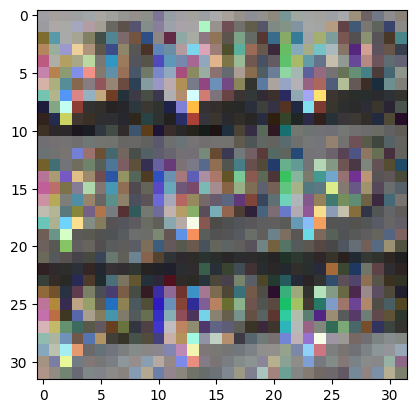

In [24]:
imagem = next(iter(test_loader))[0][0].view(32, 32, 3)
plt.imshow(imagem)

In [25]:
# (1, 1, 28, 28) - Batch_size, numero de canais, altura, largura
imagem = imagem.view(1, 3, 32, 32)
imagem.shape

torch.Size([1, 3, 32, 32])

In [26]:
net.eval()

classificador(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1152, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [27]:
imagem = imagem.to(device)

In [28]:
previsao = net.forward(imagem)
previsao

tensor([[-2.4475, -3.3298, -0.0290,  3.1376, -0.8235,  0.5471,  2.2655, -3.3585,
         -2.5395, -3.4440]], device='mps:0', grad_fn=<LinearBackward0>)

In [29]:
previsao = F.softmax(previsao)
previsao

tensor([[0.0024, 0.0010, 0.0269, 0.6386, 0.0122, 0.0479, 0.2670, 0.0010, 0.0022,
         0.0009]], device='mps:0', grad_fn=<SoftmaxBackward0>)

In [30]:
previsao = previsao.cpu().detach().numpy()
previsao

array([[0.0023969 , 0.00099192, 0.02691651, 0.638624  , 0.01216043,
        0.04788378, 0.2669914 , 0.00096391, 0.00218629, 0.0008849 ]],
      dtype=float32)

In [31]:
resultado = np.argmax(previsao)
resultado

np.int64(3)